# Prima prova di neural network

In [170]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from tqdm.notebook import tqdm, trange
from tqdm.auto import tqdm, trange
#from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
import json
import sys
import time
from importlib import reload
import cv2

In [171]:
COLOR = True
SMALL = False
LETTERS_LABEL = ['h', 's', 'u']
COLORS_LABEL = ['b', 'g', 'r']

Prendo i dati, li leggo e li splitto

In [172]:
with open('../data/images/data.json', 'r') as f:
    train = json.load(f)
labels = set()
train_img = []
y = []
for img_name, label in tqdm(train.items()):

    # addestro le lettere per vedere i colori come none
    # idem la nn per i colori, deve vedere le lettere come none
    if COLOR and label in LETTERS_LABEL:
        label = 'none'
    elif not COLOR and label in COLORS_LABEL:
        label = 'none'

    labels.add(label)


    y.append(label)
    image_path = '../data/' + str(img_name)
    img = imread(image_path, as_gray=not COLOR)
    # img = cv2.resize(img, (24, 24))
    # converting the type of pixel to float 32
    img = img.astype('float32')
    train_img.append(img)


numLabel = len(labels)
# converting the list to numpy array
X = np.array(train_img)
y = np.array(y)

  0%|          | 0/473 [00:00<?, ?it/s]

One hot encoding o Label encoding

In [173]:
oneHot = False

In [174]:
if oneHot:
    one = preprocessing.OneHotEncoder()
    y = one.fit_transform(y.reshape(-1,1)).toarray()
    pickle.dump(one, open(f'saves/oneHotEncoder{"Color" if COLOR else ""}.pickle', 'wb'))
else:
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    # print the classes
    print(le.classes_)
    pickle.dump(le, open(f'saves/labelEncoder{"Color" if COLOR else ""}.pickle', 'wb'))

['green' 'none' 'red' 'yellow']


In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)


# converting the target into torch format
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
X_train  = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

# shape of training data
X_train.shape, y_train.shape

(torch.Size([402, 24, 24, 3]), torch.Size([402]))

In [176]:
if COLOR:
    # inverto gli assi, l'rgb non e' sui singoli pixel ma diviso in tre canali diversi di immagini con pixel monovalore
    X_test = X_test.permute(0, 3, 2, 1)
    X_train = X_train.permute(0, 3, 2, 1)
else:
    # aggiungo la dimensione canale(colore), che qui e' solo una
    X_train = X_train.unsqueeze(1)
    X_test = X_test.unsqueeze(1)
y_test = y_test.type(torch.LongTensor)
y_train = y_train.type(torch.LongTensor)

In [177]:
test = TensorDataset(X_test, y_test)
train = TensorDataset(X_train, y_train)

creo i batch, randomizzando i dati, con un dataloader

In [178]:
batch_size = 50

# Create data loaders.
test = DataLoader(test, batch_size=batch_size, shuffle=True)
train = DataLoader(train, batch_size=batch_size, shuffle=True)

for X, y in test:
    print(f"Shape of X : {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X : torch.Size([50, 3, 24, 24])
Shape of y: torch.Size([50]) torch.int64


# creo la neural network

In [179]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [180]:
# moved definition to a second file, so I can dump the model and reload it from a third file
if SMALL:
    import SmallCnn
    reload(SmallCnn)
    from SmallCnn import NeuralNetwork
else:
    import CNN
    reload(CNN)
    from CNN import NeuralNetwork

In [181]:
model = NeuralNetwork(numLabel=numLabel, not_color= not COLOR).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=450, out_features=4, bias=True)
    (1): LogSoftmax(dim=1)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [182]:
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
LEARNING_RATE = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()

In [183]:
def trainf(dataloader, model, loss_fn, optimizer, print=True):
    global best_model
    best_loss = float("inf")
    size = len(dataloader.dataset)
    #model.double()
    model.train()
    #for batch , (X, Y) in tqdm(enumerate(dataloader), leave=False, total=len(dataloader), position=1, file=sys.stdout):
    for batch , (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        loss = float("inf")
        optimizer.zero_grad()
        # Compute prediction error
        #output = torch.argmax(X, dim=1).float()
        pred = model(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        # Backpropagation
        optimizer.step()

        if loss < best_loss:
            best_loss = loss
            best_model = deepcopy(model)

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_losses.append(loss)
            if print:
                tqdm.write(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [184]:
def testf(dataloader, model, loss_fn, print=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            gas_loss = [([],[]) for _ in range(5)]
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            loss = loss_fn(pred, Y).item()
            test_loss += loss
            if batch % 100 == 0:
                val_losses.append(loss)
    test_loss /= num_batches * batch_size
    if print:
        tqdm.write(f"Test Error:  Avg loss: {test_loss:>8f} \n")


In [185]:
epochs = 50
val_losses = []
train_losses = []
best_model = None
for t in trange(epochs, file=sys.stdout):
    trainf(train, model, loss_fn, optimizer, print=False)
    testf(test, model, loss_fn, print=False)
torch.save(model.state_dict(), f'saves/nn{"Color" if COLOR else ""}{"Small" if SMALL else ""}.torch')

  0%|          | 0/50 [00:00<?, ?it/s]

len(train_losses)=50


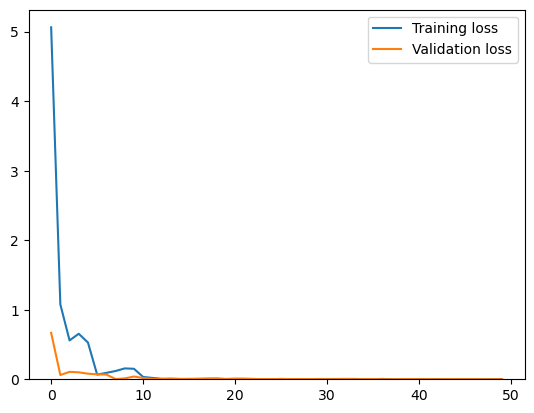

In [186]:
print(f'{len(train_losses)=}')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
# start y from 0
plt.ylim(bottom=0)
plt.show()

In [187]:
true = 0
false = 0

model.eval()
with torch.no_grad():
    for x, y in zip(X_test, y_test):
        if COLOR:
            #x = x.permute(0, 3, 2, 1)
            x = x.unsqueeze(0)
        else:
            x = x.unsqueeze(1)
        x = x.to(device)
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.cpu().numpy()[0]
        if y_pred == y:
            true += 1
        else:
            false += 1
            print(f'{y_pred=} {y=}')

print('test data')
print(f'{true=}')
print(f'{false=}')
print(f'{true/(true+false)=}')
with torch.no_grad():
    for x, y in zip(X_train, y_train):
        if COLOR:
            #x = x.permute(0, 3, 2, 1)
            x = x.unsqueeze(0)
        else:
            x = x.unsqueeze(1)
        x = x.to(device)
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.cpu().numpy()[0]
        if y_pred == y:
            true += 1
        else:
            false += 1

print('train data')
print(f'{true=}')
print(f'{false=}')
print(f'{true/(true+false)=}')

test data
true=71
false=0
true/(true+false)=1.0
train data
true=473
false=0
true/(true+false)=1.0
